PyEarth as an open source implementation of MARS is needed for curve fitting.

In [71]:
!pip install sklearn-contrib-py-earth

We use the daily spreadsheet from EU CDC containing new cases and deaths per country per day.

In [72]:
!wget -N https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx

--2021-01-08 16:06:23--  https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide.xlsx
Resolving www.ecdc.europa.eu (www.ecdc.europa.eu)... 13.227.209.26, 13.227.209.121, 13.227.209.118, ...
Connecting to www.ecdc.europa.eu (www.ecdc.europa.eu)|13.227.209.26|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘COVID-19-geographic-disbtribution-worldwide.xlsx’ not modified on server. Omitting download.



Get Pandas and NumPy for feature engineering and calculations and get plots inline.

In [73]:
import pandas as pd
import numpy  as np

from pyearth import Earth
from pyearth import export

%matplotlib inline
np.warnings.filterwarnings('ignore')

We read our dataframe directly from the downloaded Excel file and have a look at the first 10 lines for format. Data for Namibia caused missing values because the `geoId` is __NA__, so we disable interpretation of missing values.

In [74]:
df = pd.read_excel('COVID-19-geographic-disbtribution-worldwide.xlsx', keep_default_na=False, na_values='')
df.head(10)

dateRep  day  month  year  cases  deaths countriesAndTerritories geoId  \
0 2020-12-14   14     12  2020    746       6             Afghanistan    AF   
1 2020-12-13   13     12  2020    298       9             Afghanistan    AF   
2 2020-12-12   12     12  2020    113      11             Afghanistan    AF   
3 2020-12-11   11     12  2020     63      10             Afghanistan    AF   
4 2020-12-10   10     12  2020    202      16             Afghanistan    AF   
5 2020-12-09    9     12  2020    135      13             Afghanistan    AF   
6 2020-12-08    8     12  2020    200       6             Afghanistan    AF   
7 2020-12-07    7     12  2020    210      26             Afghanistan    AF   
8 2020-12-06    6     12  2020    234      10             Afghanistan    AF   
9 2020-12-05    5     12  2020    235      18             Afghanistan    AF   

  countryterritoryCode  popData2019 continentExp  \
0                  AFG   38041757.0         Asia   
1                  AFG   38041757.0         Asia   
2                  AFG   38041757.0         Asia   
3                  AFG   38041757.0         Asia   
4                  AFG   38041757.0         Asia   
5                  AFG   38041757.0         Asia   
6                  AFG   38041757.0         Asia   
7                  AFG   38041757.0         Asia   
8                  AFG   38041757.0         Asia   
9                  AFG   38041757.0         Asia   

   Cumulative_number_for_14_days_of_COVID-19_cases_per_100000  
0                                           9.013779           
1                                           7.052776           
2                                           6.868768           
3                                           7.134266           
4                                           6.968658           
5                                           6.963401           
6                                           7.094835           
7                                           7.215755           
8                                           7.326160           
9                                           7.115865

Last check of our source dataframe.

In [75]:
df.count()

dateRep                                                       61900
day                                                           61900
month                                                         61900
year                                                          61900
cases                                                         61900
deaths                                                        61900
countriesAndTerritories                                       61900
geoId                                                         61900
countryterritoryCode                                          61777
popData2019                                                   61777
continentExp                                                  61900
Cumulative_number_for_14_days_of_COVID-19_cases_per_100000    59021
dtype: int64

We pivot to a country by column format.

In [76]:
df_geo = df.pivot(index='dateRep', columns='geoId', values=['cases', 'deaths'])
df_geo

cases                                                         \
geoId         AD      AE     AF   AG   AI     AL      AM     AO      AR   
dateRep                                                                   
2019-12-31   NaN     0.0    0.0  NaN  NaN    NaN     0.0    NaN     NaN   
2020-01-01   NaN     0.0    0.0  NaN  NaN    NaN     0.0    NaN     NaN   
2020-01-02   NaN     0.0    0.0  NaN  NaN    NaN     0.0    NaN     NaN   
2020-01-03   NaN     0.0    0.0  NaN  NaN    NaN     0.0    NaN     NaN   
2020-01-04   NaN     0.0    0.0  NaN  NaN    NaN     0.0    NaN     NaN   
...          ...     ...    ...  ...  ...    ...     ...    ...     ...   
2020-12-10  35.0  1313.0  202.0  0.0  0.0  752.0  1174.0   75.0  5303.0   
2020-12-11  28.0  1255.0   63.0  0.0  0.0  873.0  1077.0  121.0  6994.0   
2020-12-12  46.0  1196.0  113.0  1.0  0.0  802.0   995.0  136.0  7112.0   
2020-12-13  52.0  1154.0  298.0  1.0  0.0  879.0  1013.0  100.0  5274.0   
2020-12-14  50.0  1194.0  746.0  0.0  0.0  788.0   357.0   27.0  3558.0   

                    ... deaths                                                  
geoId           AT  ...     VG   VI   VN   VU   WF    XK   YE     ZA   ZM   ZW  
dateRep             ...                                                         
2019-12-31     0.0  ...    NaN  NaN  0.0  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
2020-01-01     0.0  ...    NaN  NaN  0.0  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
2020-01-02     0.0  ...    NaN  NaN  0.0  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
2020-01-03     0.0  ...    NaN  NaN  0.0  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
2020-01-04     0.0  ...    NaN  NaN  0.0  NaN  NaN   NaN  NaN    NaN  NaN  NaN  
...            ...  ...    ...  ...  ...  ...  ...   ...  ...    ...  ...  ...  
2020-12-10  2913.0  ...    0.0  0.0  0.0  0.0  0.0  11.0  0.0  142.0  0.0  1.0  
2020-12-11  2466.0  ...    0.0  0.0  0.0  0.0  0.0  13.0  0.0  173.0  0.0  1.0  
2020-12-12  3026.0  ...    0.0  0.0  0.0  0.0  0.0  13.0  0.0  205.0  1.0  1.0  
2020-12-13  2938.0  ...    0.0  0.0  0.0  0.0  0.0  12.0  0.0  154.0  1.0  1.0  
2020-12-14  3005.0  ...    0.0  0.0  0.0  0.0  0.0  12.0  0.0  170.0  1.0  0.0  

[350 rows x 428 columns]

For predictions later on we need extra rows in our dataframe. One of the ways to do that is reindexing with a larger range, so we add to the current range and check our latest date.

In [77]:
new_index = pd.date_range(df_geo.index.min(), df_geo.index.max() + pd.Timedelta('365 days'))
df_geo = df_geo.reindex(new_index)
df_geo

cases                                          ... deaths           \
geoId         AD   AE   AF  AG  AI  AL   AM  AO  AR   AT  ...     VG  VI   VN   
2019-12-31   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN  0.0   
2020-01-01   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN  0.0   
2020-01-02   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN  0.0   
2020-01-03   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN  0.0   
2020-01-04   NaN  0.0  0.0 NaN NaN NaN  0.0 NaN NaN  0.0  ...    NaN NaN  0.0   
...          ...  ...  ...  ..  ..  ..  ...  ..  ..  ...  ...    ...  ..  ...   
2021-12-10   NaN  NaN  NaN NaN NaN NaN  NaN NaN NaN  NaN  ...    NaN NaN  NaN   
2021-12-11   NaN  NaN  NaN NaN NaN NaN  NaN NaN NaN  NaN  ...    NaN NaN  NaN   
2021-12-12   NaN  NaN  NaN NaN NaN NaN  NaN NaN NaN  NaN  ...    NaN NaN  NaN   
2021-12-13   NaN  NaN  NaN NaN NaN NaN  NaN NaN NaN  NaN  ...    NaN NaN  NaN   
2021-12-14   NaN  NaN  NaN NaN NaN NaN  NaN NaN NaN  NaN  ...    NaN NaN  NaN   

                                        
geoId       VU  WF  XK  YE  ZA  ZM  ZW  
2019-12-31 NaN NaN NaN NaN NaN NaN NaN  
2020-01-01 NaN NaN NaN NaN NaN NaN NaN  
2020-01-02 NaN NaN NaN NaN NaN NaN NaN  
2020-01-03 NaN NaN NaN NaN NaN NaN NaN  
2020-01-04 NaN NaN NaN NaN NaN NaN NaN  
...         ..  ..  ..  ..  ..  ..  ..  
2021-12-10 NaN NaN NaN NaN NaN NaN NaN  
2021-12-11 NaN NaN NaN NaN NaN NaN NaN  
2021-12-12 NaN NaN NaN NaN NaN NaN NaN  
2021-12-13 NaN NaN NaN NaN NaN NaN NaN  
2021-12-14 NaN NaN NaN NaN NaN NaN NaN  

[715 rows x 428 columns]

We need numerical data as inputs for a model, so we add a column representing the date as days since the start of the index.

In [78]:
df_geo['daynum'] = (df_geo.index - df_geo.index.min()).days
df_geo['daynum'].describe()

count    715.000000
mean     357.000000
std      206.547008
min        0.000000
25%      178.500000
50%      357.000000
75%      535.500000
max      714.000000
Name: daynum, dtype: float64

The typical progress of an outbreak seems to fit a Gumbel distribution, where the cumulative distribution is a double negative exponent: `exp(-exp(-x))`. The measures are averaged by week to smooth out reporting lags.

In [79]:
def gumpdf(x, beta, mu):
    """Return PDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(expon) * np.exp(- (np.exp(expon))) / beta)

def gumcdf(x, beta, mu):
    """Return CDF value according to Gumbel"""
    expon = - ((x - mu) / beta)
    return(np.exp(- (np.exp(expon))))

### Change country code or other parameters in the next cell and choose Cell, Run All Below from the menu to see the resulting output & graphs.

In [80]:
country  = 'NL'          # ISO2 country code
measure  = 'cases'       # can be cases or deaths
smeasure = 'Week window' # smoothed
rmeasure = 'rcases'      # remaining
pmeasure = 'Model'       # projected
wmeasure = 'Wave '       # waves

# Initial wave number
wave = 1

# Initialize predicted measure, create smoothed measure and remaining cases
df_geo[(pmeasure, country)] = 0
df_geo[(smeasure, country)] = df_geo[measure][country].loc[:].rolling(7).mean()
df_geo[(rmeasure, country)] = df_geo[smeasure][country]

# Always plot smoothed and predicted measures, adding waves when found
plotlist = [(smeasure, country), (pmeasure, country)]

In [81]:
# Get full name and population from the original dataset
countryname = df[df['geoId'] == country]['countriesAndTerritories'].iloc[0]
popdata = df[df['geoId'] == country]['popData2019'].iloc[0]

# We use 1 in a million cases, but at least 2
mincases = max(popdata / 1e6, 2)

In [82]:
print('Running multiple wave analysis for {} with population {:1.0f}'.format(countryname, popdata))
print('Minimum number of cases is {:1.0f}'.format(mincases))

while True:
    # Create potential wave
    curwave = wmeasure + str((wave) + 1000)[-2:]
    df_geo[(curwave, country)] = 0

    # Create a dataframe for predictions
    df_pred = pd.DataFrame({'daynum':df_geo['daynum'],
                            measure:df_geo[rmeasure][country]})

    # Create the Gumbel division and select suitable measures
    df_pred['gumdiv'] = df_pred[measure] / df_pred[measure].cumsum()
    df_pred = df_pred[(df_pred['gumdiv'] > 0) & (df_pred[measure] > mincases)]

    # Reduce to log scale and select relevant measures
    df_pred['linear'] = np.log(df_pred['gumdiv'])
    df_pred = df_pred[(df_pred['linear'] < -0.5) &
                      (df_pred['linear'] > -5.0)]

    # Do we still have data left?
    if len(df_pred) <= 1:
        print('--- no data left')
        break
    
    # Create input vectors for regression splines and build a model
    eax = df_pred['daynum'].values.reshape(-1, 1)
    eay = df_pred['linear'].values.reshape(-1, 1)
    #eamodel = Earth()
    #eamodel = Earth(minspan=0)
    eamodel = Earth(minspan=1, penalty=0, endspan=0, thresh=1e-9, check_every=1)
    eamodel.fit(eax, eay)

    # Store the results
    df_pred['earth'] = eamodel.predict(eax)

    # Find the day range
    daymin = df_pred['daynum'].min()
    daymax = df_pred['daynum'].max()

    # Find the gradient of generated regression splines
    #df_pred['gbgrad'] = np.gradient(df_pred['linear'])
    #df_pred['eagrad'] = np.gradient(df_pred['earth'])
    df_pred['gbgrad'] = df_pred['linear'] - df_pred['linear'].shift(1)
    df_pred['eagrad'] = df_pred['earth'] - df_pred['earth'].shift(1)
    
    # Knots are found when the gradient changes, including start and end
    df_pred['knot'] = ((abs(df_pred['eagrad'] - df_pred['eagrad'].shift(1)) > 1e-6) |
                       (df_pred['daynum'] == (daymin + 1)) |
                       (df_pred['daynum'] == daymax))

    # Starting day of each spline
    df_pred['daycount'] = df_pred.reset_index().index

    # Select the knots and find the actual number of days for each spline
    df_knot = df_pred[df_pred['knot']][['daynum', 'daycount', 'eagrad']]
    df_knot['daysdata'] = df_knot['daycount'].shift(-1) - df_knot['daycount']
    df_knot['daystime'] = df_knot['daynum'].shift(-1) - df_knot['daynum']

    # Candidate knots have a negative gradient and a minimum number of days
    df_knot['cand'] = ((df_knot['eagrad'] < -1/44) &
                       (df_knot['daysdata'] >= 3))

    # We want early knots with a low gradient and many days
    df_knot['since'] = df_knot['daynum'] - daymin
    df_knot['score'] = (df_knot['eagrad'] ** 2) * np.sqrt(df_knot['daysdata'] / np.sqrt(df_knot['since']))
    df_knot['choice'] = df_knot['score'] == df_knot[df_knot['cand']]['score'].max()

    # Did we find another wave?
    choice = df_knot[df_knot['choice']]
    if len(choice) == 0:
        print('--- no data left')
        break
    
    # Find the interval of the selected spline
    lower = choice['daynum'].values[0]
    upper = choice['daysdata'].values[0] + lower
    df_pred = df_pred[(df_pred['daynum'] >= lower) &
                      (df_pred['daynum'] <= upper)].copy()

    # Calculate slope and intercept as basis for beta and mu
    fitmod = export.export_python_function(eamodel)
    slope = (fitmod([[upper]])[0] - fitmod([[lower]])[0]) / (upper - lower)
    intercept = fitmod([[lower]])[0] - (lower * slope)
    beta = - 1 / slope
    mu = beta * (intercept + np.log(beta))

    # Apply the Gumbel PDF according to beta and mu and find the scale
    df_pred['pgumb'] = gumpdf(df_pred['daynum'], beta, mu)
    df_pred['scale'] = df_pred[measure] / df_pred['pgumb']
    final = df_pred['scale'].mean()
    fincv = df_pred['scale'].std() / final

    # Calculate the current wave and its parameters
    df_geo[(curwave, country)] = final * gumpdf(df_geo['daynum'], beta, mu)
    peak = df_geo[df_geo[(curwave, country)] == df_geo[(curwave, country)].max()].index.min()
    start = df_geo[(df_geo[(curwave, country)] >= 1) &
                   (df_geo[(curwave, country)].index < peak)].index.min()
    floor = df_geo[(df_geo[(curwave, country)] < 1) &
                   (df_geo[(curwave, country)].index > peak)].index.min()
    print('{} beta {:6.3f} mu {:3.0f} fit {:5.3f} peak {} from {} to {} size {:1.0f}'.format(
        curwave, beta, mu, (1 - fincv) ** 2, peak.date(), start.date(), floor.date(), final))

    # Move the data from remainder to prediction
    df_geo[(pmeasure, country)] += df_geo[(curwave, country)]
    df_geo[(rmeasure, country)] -= df_geo[(curwave, country)]
    plotlist += [(curwave, country)]
    wave += 1

Running multiple wave analysis for Netherlands with population 17282163
Minimum number of cases is 17
Wave 01 beta 18.895 mu 103 fit 0.689 peak 2020-04-12 from 2020-02-28 to 2020-09-09 size 51380
Wave 02 beta  2.351 mu  92 fit 0.670 peak 2020-04-01 from 2020-03-27 to 2020-04-16 size 1167
Wave 03 beta  3.817 mu 107 fit 0.826 peak 2020-04-16 from 2020-04-08 to 2020-05-08 size 1213
Wave 04 beta  5.320 mu 221 fit 0.940 peak 2020-08-08 from 2020-07-28 to 2020-09-16 size 6485
Wave 05 beta  7.308 mu 234 fit 0.787 peak 2020-08-21 from 2020-08-05 to 2020-10-13 size 9981
Wave 06 beta  6.763 mu 251 fit 0.863 peak 2020-09-07 from 2020-08-23 to 2020-10-25 size 7727
Wave 07 beta  8.044 mu 264 fit 0.899 peak 2020-09-20 from 2020-09-01 to 2020-11-23 size 22993
Wave 08 beta  6.365 mu 272 fit 0.782 peak 2020-09-28 from 2020-09-14 to 2020-11-21 size 25256
Wave 09 beta 16.485 mu 301 fit 0.874 peak 2020-10-27 from 2020-09-16 to 2021-04-13 size 411035
Wave 10 beta 15.880 mu 351 fit 0.634 peak 2020-12-16 fro

In [83]:
df_geo[plotlist].loc['20200301':'20210301'].plot(
    figsize=(16, 9),
    grid=True,
    kind='area',
    stacked=False,
    alpha=1/3,
    title='Daily new cases for '+countryname)
df_geo[plotlist].loc['20200301':'20210301'].cumsum().plot(
    figsize=(16, 9),
    grid=True,
    kind='area',
    stacked=False,
    alpha=1/3,
    title='Cumulative cases for '+countryname)

We have the estimate for the final number of cases, so the progress would be the current number of cases divided by the final number. This could end up over 100%, if we estimate that the current wave of the outbreak is over and new cases are due to relaxing of measures, increase in testing or other factors.

In [84]:
progress = df_geo[measure][country].sum() / df_geo[pmeasure][country].sum()
print('Currently at {:1.2f}% of {:1.0f}'.format(progress * 100, df_geo[pmeasure][country].sum()))

Currently at 81.12% of 755356


The peak date is at the maximum value.

In [85]:
peak = df_geo[df_geo[(pmeasure, country)] == df_geo[(pmeasure, country)].max()].index.min()
print('Peak at {}'.format(peak.date()))

Peak at 2020-10-27


This date should closely match the `mu` of our distribution, in days since the start of the index.

In [86]:
print('Peak by last mu at {}'.format(df_geo.loc[df_geo['daynum'] == mu.astype(int)].index[0].date()))

Peak by last mu at 2020-12-16


The floor is defined as the first time that the number of reported cases falls below 1 in a million, which is the first time that happens *after* the peak.

In [87]:
floor = df_geo[(df_geo[(pmeasure, country)] < (popdata / 1e6)) &
               (df_geo[(pmeasure, country)].index > peak)].index.min()
print('Floor at {}'.format(floor.date()))

Floor at 2021-04-04


Similarly, we can calculate the start as the first day where the number of cases was above 1 in a million before the peak.

In [88]:
start = df_geo[(df_geo[(pmeasure, country)] > (popdata / 1e6)) &
               (df_geo[(pmeasure, country)].index < peak)].index.min()
print('Start at {}'.format(start.date()))

Start at 2020-03-06


We define the maximum delta as the day in the curve with the sharpest rise.

In [89]:
maxrise = (df_geo[(pmeasure, country)] - df_geo[(pmeasure, country)].shift()).max()
maxdelta = df_geo[(df_geo[(pmeasure, country)] - df_geo[(pmeasure, country)].shift()) == (
    maxrise)].index.min()
print('Largest rise of {:1.0f} on {}'.format(maxrise, maxdelta.date()))

Largest rise of 391 on 2020-10-13


This should match the maximum gradient of the daily data.

In [90]:
print('Maximum gradient is {:1.0f}'.format(np.gradient(df_geo[(pmeasure, country)]).max()))

Maximum gradient is 391


Back to the original curve, showing the number of infected concurrently.

In [91]:
df_geo[pmeasure][country].rolling(14).sum().loc[start:floor].plot(
    figsize=(16, 9), grid=True, kind='area', stacked=False, alpha=1/3)

The top of this curve gives the maximum number of people that are infected at the same time.

In [92]:
print('Maximum infected is {:1.0f}'.format(df_geo[pmeasure][country].rolling(14).sum().max()))

Maximum infected is 125756


If we look at the difference between our actual (smoothed) value and our prediction, we can clearly see if the curve is breaking out after the floor. This can be the result of relaxing of measures and the beginning of a second wave, an increase in testing or other factors.

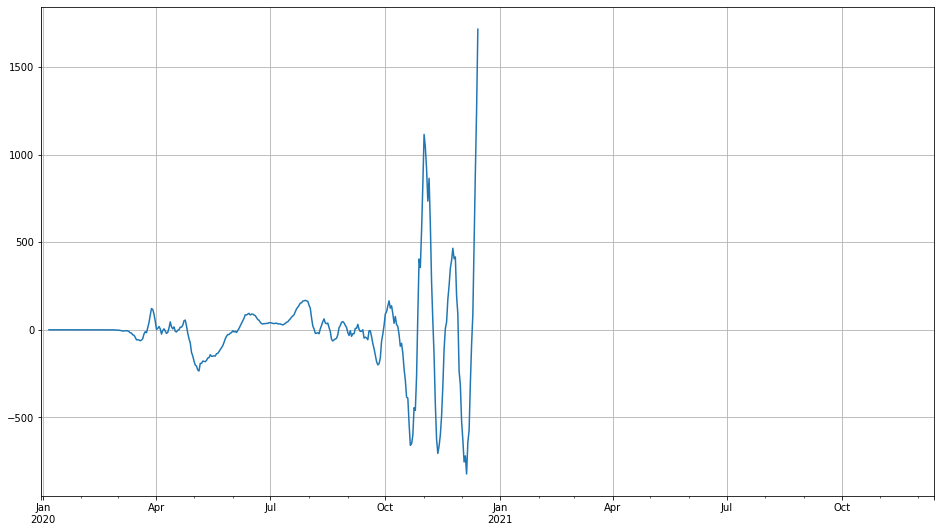

In [93]:
(df_geo[(smeasure, country)] - df_geo[(pmeasure, country)]).rolling(1).mean().loc[:].plot(
    figsize=(16, 9), grid=True)

Keep exploring! Stay home, wash your hands, keep your distance.